# IBM Data Science Capstone Project: It's a (Tourist) Trap!

## Background:
When visiting a new destination for the first time, tourists are faced with a big decision, that is the task of finding accommodation. Oftentimes these tourists fall for tourist traps and are charged ridiculous prices for their accommodation. Conversely, these tourists might not do adequate research and book accommodation that is far away from the points of interest that they are yet to discover. This decreases the quality of their holiday experience, and increases the cost of travelling, which could otherwise have been spent on fun activities.

## Problem Definition:
Jonathan is a student who is planning on doing a semester abroad at Reutlingen University in Germany. During his stay abroad he is planning on visiting Stuttgart, however, he is unsure of where he should be looking for accommodation. This project aims to use data science and visualisation techniques to find the best neighbourhoods, offering accommodation, that are optimal for tourists in Stuttgart.

## Discussion of Data:
This project entails the use of the **Foursquare** API which will be accessed through python to:
1. Obtain the names of all of the neighbourhoods in Stuttgart.
1. Find all of the most popular venues listed for each neighbourhood.
1. Display the frequency of occurance of each type of venue.
1. Compare each neighbourhood in Stuttgart to each neighbourhood in Cape Town.


### Code

#### Importing all libraries

In [1]:
import json 
import pandas as pd
import numpy as np

%pip install geopy
from geopy.geocoders import Nominatim 

from bs4 import BeautifulSoup 

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium 

#### Scraping all of the neighbourhoods in Stuttgart

In [2]:
url = 'https://www.movingto-germany.com/stuttgart/'
data  = requests.get(url).text 
soup = BeautifulSoup(data,"html5lib") 

In [3]:
address = 'Stuttgart'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Stuttgart are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Stuttgart are 48.7784485, 9.1800132.


Get all of the neighbourhoods in Stuttgart

In [4]:
stuttgart_suburbs = pd.DataFrame(columns=["Suburb"])

lists = soup.find('ul', {'class':''}) 

suburbs= lists.find_all('li')

for i in range(len(suburbs)):
  stuttgart_suburbs = stuttgart_suburbs.append({"Suburb":suburbs[i].text}, ignore_index=True)

stuttgart_suburbs.shape

(23, 1)

Get all of the geospatial data associated with these neighbourhoods

In [5]:
stuttgart_data = pd.DataFrame(columns=["Suburb", "Latitude", "Longitude"])

for index, row in stuttgart_suburbs.iterrows():
  address = row['Suburb']

  geolocator = Nominatim(user_agent="to_explorer")
  location = geolocator.geocode(address)
  latitude = location.latitude
  longitude = location.longitude

  stuttgart_data = stuttgart_data.append({"Suburb":address, "Latitude":latitude, "Longitude":longitude}, ignore_index=True)
stuttgart_data.dtypes

Suburb        object
Latitude     float64
Longitude    float64
dtype: object

#### Displaying all of the neighbourhoods

In [6]:
map_stuttgart = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, suburb in zip(stuttgart_data['Latitude'], stuttgart_data['Longitude'], stuttgart_data['Suburb']):
    label = '{}'.format(suburb)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stuttgart)  
    
map_stuttgart

In [7]:
CLIENT_ID = 'sneaky' # your Foursquare ID
CLIENT_SECRET = 'beaky' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HCIWEYMLE0SJAI3ESV4AFX5PNQVBSLP5HQ1YU4GISAHHRIFV
CLIENT_SECRET:P4KVBEVJDIVREULUPIZHUL124JX353PUIP5KWJOGX1PLDB5B


In [8]:
def getNearbyVenues(names, latitudes, longitudes, section, radius=1000):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&query={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            section,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
stuttgart_venues = getNearbyVenues(names=stuttgart_data['Suburb'],
                                   latitudes=stuttgart_data['Latitude'],
                                   longitudes=stuttgart_data['Longitude'],
                                   section = "nightlife"
                                  )

stuttgart_venues

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Stuttgart-Mitte,48.775900,9.179800,Bix Jazzclub,48.773178,9.179495,Jazz Club
1,Stuttgart-Mitte,48.775900,9.179800,Eduard's,48.775537,9.179935,Cocktail Bar
2,Stuttgart-Mitte,48.775900,9.179800,TATTI,48.774353,9.177209,Café
3,Stuttgart-Mitte,48.775900,9.179800,Mata Hari,48.773798,9.177704,Bar
4,Stuttgart-Mitte,48.775900,9.179800,"Brenner Drinks, Food etc.",48.774059,9.182335,Bar
...,...,...,...,...,...,...,...
207,Weilimdorf,48.815276,9.112444,Corner Pub,48.815468,9.111614,Pub
208,Weilimdorf,48.815276,9.112444,Stuttgarter Hofbräu,48.813659,9.111559,Brewery
209,Weilimdorf,48.815276,9.112444,Bar Emozioni,48.812521,9.110793,Bar
210,Weilimdorf,48.815276,9.112444,Arena,48.818143,9.108253,Pub


In [10]:
print(stuttgart_venues.shape)
stuttgart_venues.head()

(212, 7)


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Stuttgart-Mitte,48.7759,9.1798,Bix Jazzclub,48.773178,9.179495,Jazz Club
1,Stuttgart-Mitte,48.7759,9.1798,Eduard's,48.775537,9.179935,Cocktail Bar
2,Stuttgart-Mitte,48.7759,9.1798,TATTI,48.774353,9.177209,Café
3,Stuttgart-Mitte,48.7759,9.1798,Mata Hari,48.773798,9.177704,Bar
4,Stuttgart-Mitte,48.7759,9.1798,"Brenner Drinks, Food etc.",48.774059,9.182335,Bar


In [11]:
stuttgart_top_venues = stuttgart_venues.groupby('Suburb').count()

stuttgart_top_venues.drop(['Suburb Longitude', 'Suburb Latitude', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], axis=1, inplace=True)

stuttgart_top_venues = stuttgart_top_venues.rename(columns={'Venue':'Total venues'})

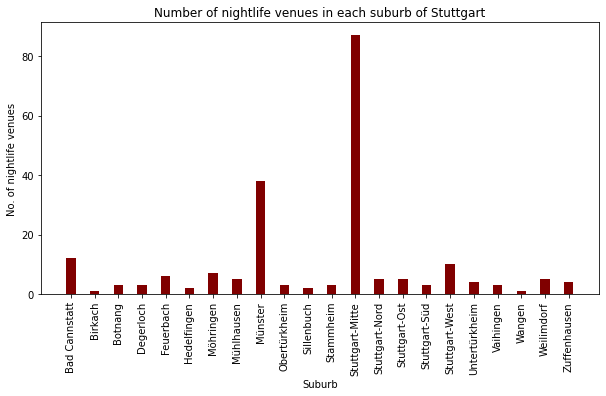

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5))

subbois = []
tallys = []
for index, row in stuttgart_top_venues.iterrows():
  subbois.append(index)
  tallys.append(row[0])
# creating the bar plot
y_pos = range(len(subbois))
plt.bar(y_pos, tallys, color ='maroon', width = 0.4)

plt.xticks(y_pos, subbois, rotation=90)
 
plt.xlabel("Suburb")
plt.ylabel("No. of nightlife venues")
plt.title("Number of nightlife venues in each suburb of Stuttgart")
plt.show()

In [13]:
  print('There are {} uniques categories.'.format(len(stuttgart_venues['Venue Category'].unique())))

  stuttgart_venues['Venue Category'].value_counts()

There are 39 uniques categories.


Bar                           50
Nightclub                     20
Pub                           19
Gastropub                     16
Lounge                        14
Cocktail Bar                  10
Beer Garden                    9
German Restaurant              8
Café                           8
Hookah Bar                     7
Sports Bar                     6
Burger Joint                   4
Hotel                          3
Wine Bar                       3
Hotel Bar                      3
Brewery                        3
Restaurant                     3
Jazz Club                      2
Beach Bar                      2
Wine Shop                      2
Gay Bar                        2
Spanish Restaurant             1
Bakery                         1
Speakeasy                      1
Piano Bar                      1
Pizza Place                    1
Whisky Bar                     1
Sushi Restaurant               1
Modern European Restaurant     1
Bowling Alley                  1
Bistro    

#### Analyze each neighbourhood's nightlife

In [14]:
# one hot encoding
stuttgart_onehot = pd.get_dummies(stuttgart_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
stuttgart_onehot['Suburb'] = stuttgart_venues['Suburb'] 

# move neighborhood column to the first column
fixed_columns = [stuttgart_onehot.columns[-1]] + list(stuttgart_onehot.columns[:-1])
stuttgart_onehot = stuttgart_onehot[fixed_columns]

stuttgart_grouped = stuttgart_onehot.groupby('Suburb').mean().reset_index()

In [15]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [16]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Suburb'] = stuttgart_grouped['Suburb']

for ind in np.arange(stuttgart_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(stuttgart_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bad Cannstatt,Bar,Café,Beer Garden,Gastropub,Sports Bar,Hotel Bar,Boat or Ferry,Lounge,Wine Shop,Event Space
1,Birkach,Gastropub,Wine Shop,Brewery,Gay Bar,Event Space,Deli / Bodega,Cocktail Bar,Café,Burger Joint,Breakfast Spot
2,Botnang,Bar,Gastropub,Pub,Wine Shop,Brewery,Gay Bar,Event Space,Deli / Bodega,Cocktail Bar,Café
3,Degerloch,Pub,Bar,Wine Shop,Brewery,Gay Bar,Gastropub,Event Space,Deli / Bodega,Cocktail Bar,Café
4,Feuerbach,Hookah Bar,Bar,Gastropub,Restaurant,Pub,German Restaurant,Burger Joint,Gay Bar,Event Space,Deli / Bodega


#### Clustering the neighbourhoods based on nightlife activities

In [17]:
# set number of clusters
kclusters = 5

stuttgart_grouped_clustering = stuttgart_grouped.drop('Suburb', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(stuttgart_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 4, 2, 2, 0, 1, 2, 0, 2, 0], dtype=int32)

In [18]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

stuttgart_merged = stuttgart_data

# merge stuttgart_grouped with stuttgart_data to add latitude/longitude for each neighborhood
stuttgart_merged = stuttgart_merged.join(neighborhoods_venues_sorted.set_index('Suburb'), on='Suburb')

stuttgart_merged.head() # check the last columns!

,Suburb,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Stuttgart-Mitte,48.775900,9.179800,0.0,Bar,Nightclub,Cocktail Bar,Lounge,German Restaurant,Café,Wine Bar,Jazz Club,Burger Joint,Sports Bar
1,Stuttgart-Nord,48.796661,9.176252,0.0,Asian Restaurant,Burger Joint,Hotel Bar,Beer Garden,Nightclub,Gastropub,Event Space,Deli / Bodega,Cocktail Bar,Café
2,Stuttgart-Ost,48.776972,9.207365,2.0,Bar,Beer Garden,Lounge,Pub,Wine Shop,Burger Joint,Gastropub,Event Space,Deli / Bodega,Cocktail Bar
3,Stuttgart-Süd,48.753021,9.132492,4.0,Gastropub,Lounge,Wine Shop,Hookah Bar,Gay Bar,Event Space,Deli / Bodega,Cocktail Bar,Café,Burger Joint
4,Stuttgart-West,48.777659,9.151351,2.0,Bar,Pub,Gastropub,Sports Bar,German Restaurant,Wine Shop,Brewery,Event Space,Deli / Bodega,Cocktail Bar


In [19]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(stuttgart_merged['Latitude'], stuttgart_merged['Longitude'], stuttgart_merged['Suburb'], stuttgart_merged['Cluster Labels']):
  if cluster == cluster:
    label = folium.Popup(str(poi) + ', Cluster ' + str(int(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=40,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examining the clusters based on nightlife venues

Cluster 0:

In [20]:
stuttgart_merged.loc[stuttgart_merged['Cluster Labels'] == 0, stuttgart_merged.columns[[0] + list(range(5, stuttgart_merged.shape[1]))]]

,Suburb,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Stuttgart-Mitte,Nightclub,Cocktail Bar,Lounge,German Restaurant,Café,Wine Bar,Jazz Club,Burger Joint,Sports Bar
1,Stuttgart-Nord,Burger Joint,Hotel Bar,Beer Garden,Nightclub,Gastropub,Event Space,Deli / Bodega,Cocktail Bar,Café
5,Bad Cannstatt,Café,Beer Garden,Gastropub,Sports Bar,Hotel Bar,Boat or Ferry,Lounge,Wine Shop,Event Space
10,Untertürkheim,Bar,Gastropub,Hookah Bar,Burger Joint,Gay Bar,Event Space,Deli / Bodega,Cocktail Bar,Café
12,Zuffenhausen,Hookah Bar,Gastropub,Nightclub,Gay Bar,Event Space,Deli / Bodega,Cocktail Bar,Café,Burger Joint
13,Feuerbach,Bar,Gastropub,Restaurant,Pub,German Restaurant,Burger Joint,Gay Bar,Event Space,Deli / Bodega
17,Mühlhausen,Bar,Sports Bar,Beer Garden,Cocktail Bar,Burger Joint,Gay Bar,Gastropub,Event Space,Deli / Bodega
19,Obertürkheim,Lounge,Pub,Brewery,Gay Bar,Gastropub,Event Space,Deli / Bodega,Cocktail Bar,Café


Cluster 1:

In [21]:
stuttgart_merged.loc[stuttgart_merged['Cluster Labels'] == 1, stuttgart_merged.columns[[0] + list(range(5, stuttgart_merged.shape[1]))]]

,Suburb,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Stammheim,Hookah Bar,Wine Shop,Burger Joint,Gay Bar,Gastropub,Event Space,Deli / Bodega,Cocktail Bar,Café
11,Vaihingen,Deli / Bodega,Wine Shop,Brewery,Gay Bar,Gastropub,Event Space,Cocktail Bar,Café,Burger Joint
16,Hedelfingen,Lounge,Wine Shop,Burger Joint,Gay Bar,Gastropub,Event Space,Deli / Bodega,Cocktail Bar,Café


Cluster 2:

In [22]:
stuttgart_merged.loc[stuttgart_merged['Cluster Labels'] == 2, stuttgart_merged.columns[[0] + list(range(5, stuttgart_merged.shape[1]))]]

,Suburb,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Stuttgart-Ost,Beer Garden,Lounge,Pub,Wine Shop,Burger Joint,Gastropub,Event Space,Deli / Bodega,Cocktail Bar
4,Stuttgart-West,Pub,Gastropub,Sports Bar,German Restaurant,Wine Shop,Brewery,Event Space,Deli / Bodega,Cocktail Bar
6,Degerloch,Bar,Wine Shop,Brewery,Gay Bar,Gastropub,Event Space,Deli / Bodega,Cocktail Bar,Café
7,Möhringen,Gastropub,Beach Bar,Pub,Wine Shop,Burger Joint,Gay Bar,Event Space,Deli / Bodega,Cocktail Bar
15,Botnang,Gastropub,Pub,Wine Shop,Brewery,Gay Bar,Event Space,Deli / Bodega,Cocktail Bar,Café
18,Münster,Pub,Nightclub,Café,Gastropub,Lounge,Sports Bar,Spanish Restaurant,German Restaurant,Whisky Bar
20,Sillenbuch,Pub,Wine Shop,Brewery,Gay Bar,Gastropub,Event Space,Deli / Bodega,Cocktail Bar,Café
22,Weilimdorf,Bar,Beer Garden,Brewery,Wine Shop,Burger Joint,Gay Bar,Gastropub,Event Space,Deli / Bodega


Cluster 3

In [23]:
stuttgart_merged.loc[stuttgart_merged['Cluster Labels'] == 3, stuttgart_merged.columns[[0] + list(range(5, stuttgart_merged.shape[1]))]]

,Suburb,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Wangen,Wine Shop,Hookah Bar,Gay Bar,Gastropub,Event Space,Deli / Bodega,Cocktail Bar,Café,Burger Joint


Cluster 4

In [24]:
stuttgart_merged.loc[stuttgart_merged['Cluster Labels'] == 4, stuttgart_merged.columns[[0] + list(range(5, stuttgart_merged.shape[1]))]]

,Suburb,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Stuttgart-Süd,Lounge,Wine Shop,Hookah Bar,Gay Bar,Event Space,Deli / Bodega,Cocktail Bar,Café,Burger Joint
14,Birkach,Wine Shop,Brewery,Gay Bar,Event Space,Deli / Bodega,Cocktail Bar,Café,Burger Joint,Breakfast Spot


#### Finding all of the cheap hotels in each stuttgart suburb

In [25]:
stuttgart_hotels = getNearbyVenues(names=stuttgart_data['Suburb'],
                                   latitudes=stuttgart_data['Latitude'],
                                   longitudes=stuttgart_data['Longitude'],
                                   section = "cheap hotels"
                                  )

stuttgart_hotels  

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Stuttgart-Mitte,48.775900,9.179800,Motel One Stuttgart-Hauptbahnhof,48.782072,9.179033,Hotel
1,Stuttgart-Mitte,48.775900,9.179800,City Hotel Stuttgart,48.774991,9.187461,Hotel
2,Stuttgart-Nord,48.796661,9.176252,Mercure Hotel Stuttgart City Center,48.793174,9.182213,Hotel
3,Stuttgart-West,48.777659,9.151351,Hotel Sautter,48.776981,9.162101,Hotel
4,Bad Cannstatt,48.804883,9.214680,Hotel Spahr,48.804974,9.225166,Hotel
5,Zuffenhausen,48.831299,9.167440,B&B Hotel Stuttgart-Zuffenhausen,48.832580,9.154400,Hotel
6,Zuffenhausen,48.831299,9.167440,Mercure Hotel Stuttgart Zuffenhausen,48.834457,9.162191,Hotel
7,Zuffenhausen,48.831299,9.167440,Mercure Hotel Stuttgart Zuffenhausen,48.834673,9.162012,Hotel
8,Obertürkheim,48.764789,9.268515,Brita Hotel Stuttgart,48.762617,9.269398,Hotel


In [26]:

# add markers to map
for lat, lng, name in zip(stuttgart_hotels['Venue Latitude'], stuttgart_hotels['Venue Longitude'], stuttgart_hotels['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)  
    
map_clusters